In [45]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [ ]:
https://www.kaggle.com/incorpes/glove6b200d

In [46]:
token_path = "Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
train_images_path = 'Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_images_path = 'Flickr_Data/Flickr_TextData//Flickr_8k.testImages.txt'
images_path = 'Flickr_Data/Images/'
glove_path = ''

doc = open(token_path,'r').read()
print(doc[:410])


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [47]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [86]:
descriptions

{'1000268201_693b08cb0e': ['a child in a pink dress is climbing up a set of stairs in an entry way ',
  'a girl going into a wooden building ',
  'a little girl climbing into a wooden playhouse ',
  'a little girl climbing the stairs to her playhouse ',
  'a little girl in a pink dress going into a wooden cabin '],
 '1001773457_577c3a7d70': ['a black dog and a spotted dog are fighting',
  'a black dog and a tricolored dog playing with each other on the road ',
  'a black dog and a white dog with brown spots are staring at each other in the street ',
  'two dogs of different breeds looking at each other on the road ',
  'two dogs on pavement moving toward each other '],
 '1002674143_1b742ab4b8': ['a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl ',
  'a little girl is sitting in front of a large painted rainbow ',
  'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it ',
  'there is a girl with pigta

In [48]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

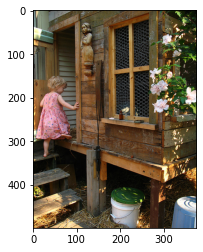

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [49]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [50]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [51]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [23]:
len(descriptions.keys())

8092

In [52]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [53]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [87]:
train_img

['Flickr_Data/Images/2387197355_237f6f41ee.jpg',
 'Flickr_Data/Images/2609847254_0ec40c1cce.jpg',
 'Flickr_Data/Images/2046222127_a6f300e202.jpg',
 'Flickr_Data/Images/2853743795_e90ebc669d.jpg',
 'Flickr_Data/Images/2696951725_e0ae54f6da.jpg',
 'Flickr_Data/Images/3421131122_2e4bde661e.jpg',
 'Flickr_Data/Images/3229730008_63f8ca2de2.jpg',
 'Flickr_Data/Images/3220009216_10f088185e.jpg',
 'Flickr_Data/Images/3415578043_03d33e6efd.jpg',
 'Flickr_Data/Images/3437273677_47d4462974.jpg',
 'Flickr_Data/Images/3543600125_223747ef4c.jpg',
 'Flickr_Data/Images/2594459477_8ca0121a9a.jpg',
 'Flickr_Data/Images/3387630781_f421a94d9d.jpg',
 'Flickr_Data/Images/3591094476_b61acd63d6.jpg',
 'Flickr_Data/Images/3155501473_510f9c9f6b.jpg',
 'Flickr_Data/Images/2521062020_f8b983e4b2.jpg',
 'Flickr_Data/Images/3564007203_df2b8010f1.jpg',
 'Flickr_Data/Images/2443229844_277cded27d.jpg',
 'Flickr_Data/Images/772212710_f5fc22ed35.jpg',
 'Flickr_Data/Images/2269021076_cefc9af989.jpg',
 'Flickr_Data/Images/

In [54]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [55]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [88]:
all_train_captions

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq',
 'startseq a little girl is sitting in front of a large painted rainbow endseq',
 'startseq a small girl in the grass play

In [56]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [57]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [89]:
ixtoword

{1: 'startseq',
 2: 'a',
 3: 'child',
 4: 'in',
 5: 'pink',
 6: 'dress',
 7: 'is',
 8: 'climbing',
 9: 'up',
 10: 'set',
 11: 'of',
 12: 'stairs',
 13: 'an',
 14: 'way',
 15: 'endseq',
 16: 'girl',
 17: 'going',
 18: 'into',
 19: 'wooden',
 20: 'building',
 21: 'little',
 22: 'the',
 23: 'to',
 24: 'her',
 25: 'black',
 26: 'dog',
 27: 'and',
 28: 'spotted',
 29: 'are',
 30: 'fighting',
 31: 'tricolored',
 32: 'playing',
 33: 'with',
 34: 'each',
 35: 'other',
 36: 'on',
 37: 'road',
 38: 'white',
 39: 'brown',
 40: 'spots',
 41: 'staring',
 42: 'at',
 43: 'street',
 44: 'two',
 45: 'dogs',
 46: 'different',
 47: 'looking',
 48: 'pavement',
 49: 'moving',
 50: 'toward',
 51: 'covered',
 52: 'paint',
 53: 'sits',
 54: 'front',
 55: 'painted',
 56: 'rainbow',
 57: 'hands',
 58: 'bowl',
 59: 'sitting',
 60: 'large',
 61: 'small',
 62: 'grass',
 63: 'plays',
 64: 'it',
 65: 'there',
 66: 'pigtails',
 67: 'painting',
 68: 'young',
 69: 'outside',
 70: 'man',
 71: 'lays',
 72: 'bench',
 73: 

In [58]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [59]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = nmodel = InceptionV3(weights='imagenet')
p.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [60]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [92]:
len(embedding_matrix[0])

200

In [61]:
model = InceptionV3(weights='imagenet')

In [62]:
model_new = Model(model.input, model.layers[-2].output)


In [63]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [65]:
from tqdm import tqdm

def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images_path):]] = encode(img)

100%|██████████| 1000/1000 [01:29<00:00, 11.16it/s]


In [66]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 200)      332000      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_8[0][0]                    
____________________________________________________________________________________________

In [67]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [68]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [105]:
descriptions.items()

dict_items([('1000268201_693b08cb0e', ['a child in a pink dress is climbing up a set of stairs in an entry way ', 'a girl going into a wooden building ', 'a little girl climbing into a wooden playhouse ', 'a little girl climbing the stairs to her playhouse ', 'a little girl in a pink dress going into a wooden cabin ']), ('1001773457_577c3a7d70', ['a black dog and a spotted dog are fighting', 'a black dog and a tricolored dog playing with each other on the road ', 'a black dog and a white dog with brown spots are staring at each other in the street ', 'two dogs of different breeds looking at each other on the road ', 'two dogs on pavement moving toward each other ']), ('1002674143_1b742ab4b8', ['a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl ', 'a little girl is sitting in front of a large painted rainbow ', 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it ', 'there is a girl with pigtails sitt

In [ ]:
for key, desc_list in descriptions.items():
            # retrieve the photo feature
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    print(in_seq)
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    print(out_seq)
                    # store
                    
                   

In [69]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    print()

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [83]:
len(train_features['3046286572_d2050ab0d9.jpg'])

2048

In [85]:
max_length

38

In [72]:
epochs = 3
batch_size = 100
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/3
60/60 [==============================] - 248s 4s/step - loss: 3.5925
Epoch 2/3
60/60 [==============================] - 248s 4s/step - loss: 3.4665
Epoch 3/3
60/60 [==============================] - 249s 4s/step - loss: 3.3675


In [101]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        print(photo)
        print(len(photo[0]))
        print(sequence)
        
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        print(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [74]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

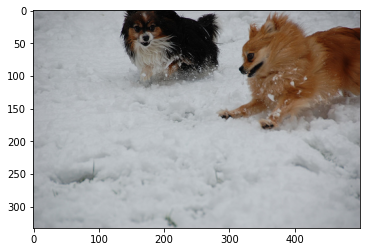

[[0.14477931 0.14842904 0.13912192 ... 0.755217   0.07503642 0.12203375]]
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]]
2
[[0.14477931 0.14842904 0.13912192 ... 0.755217   0.07503642 0.12203375]]
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 2]]
26
[[0.14477931 0.14842904 0.13912192 ... 0.755217   0.07503642 0.12203375]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  1  2 26]]
7
[[0.14477931 0.14842904 0.13912192 ... 0.755217   0.07503642 0.12203375]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  1  2 26  7]]
106
[[0.14477931 0.14842904 0.13912192 ... 0.755217   0.07503642 0.12203375]]
2048
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2  26
    7 106]]
111
[[0.14477931 0.14842904 0.

In [102]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
#print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
#print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
#print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
#print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [103]:
ixtoword

{1: 'startseq',
 2: 'a',
 3: 'child',
 4: 'in',
 5: 'pink',
 6: 'dress',
 7: 'is',
 8: 'climbing',
 9: 'up',
 10: 'set',
 11: 'of',
 12: 'stairs',
 13: 'an',
 14: 'way',
 15: 'endseq',
 16: 'girl',
 17: 'going',
 18: 'into',
 19: 'wooden',
 20: 'building',
 21: 'little',
 22: 'the',
 23: 'to',
 24: 'her',
 25: 'black',
 26: 'dog',
 27: 'and',
 28: 'spotted',
 29: 'are',
 30: 'fighting',
 31: 'tricolored',
 32: 'playing',
 33: 'with',
 34: 'each',
 35: 'other',
 36: 'on',
 37: 'road',
 38: 'white',
 39: 'brown',
 40: 'spots',
 41: 'staring',
 42: 'at',
 43: 'street',
 44: 'two',
 45: 'dogs',
 46: 'different',
 47: 'looking',
 48: 'pavement',
 49: 'moving',
 50: 'toward',
 51: 'covered',
 52: 'paint',
 53: 'sits',
 54: 'front',
 55: 'painted',
 56: 'rainbow',
 57: 'hands',
 58: 'bowl',
 59: 'sitting',
 60: 'large',
 61: 'small',
 62: 'grass',
 63: 'plays',
 64: 'it',
 65: 'there',
 66: 'pigtails',
 67: 'painting',
 68: 'young',
 69: 'outside',
 70: 'man',
 71: 'lays',
 72: 'bench',
 73: 

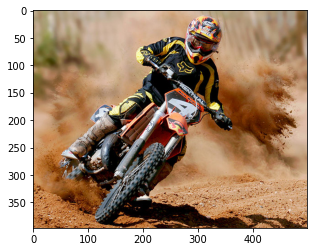

[[0.0833569  0.4748031  0.         ... 0.41408825 0.34601712 0.32229516]]
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]]
2
[[0.0833569  0.4748031  0.         ... 0.41408825 0.34601712 0.32229516]]
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 2]]
70
[[0.0833569  0.4748031  0.         ... 0.41408825 0.34601712 0.32229516]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  1  2 70]]
4
[[0.0833569  0.4748031  0.         ... 0.41408825 0.34601712 0.32229516]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  1  2 70  4]]
2
[[0.0833569  0.4748031  0.         ... 0.41408825 0.34601712 0.32229516]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  1  2 70  4  2]]
413
[[0.0833569  0.4748031  0.         ... 0.41408825 0.34601712 0.32229

In [104]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
#print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
#print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
#print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))